In [1]:
import os
import time
import datetime
import netCDF4
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.cluster import DBSCAN

In [2]:
s3bands = [
    'B1-400',
    'B2-412.5',
    'B3-442.5',
    'B4-490',
    'B5-510',
    'B6-560',
    'B7-620',
    'B8-665',
    'B9-673.75',
    'B10-681.25',
    'B11-708.75',
    'B12-753.75',
    'B16-778.75',
    'B17-865',
    'B18-885',
    'B21-1020'
]

# s3bands = [400, 412.5, 442, 490, 510, 560, 620, 665, 674, 681, 709, 754, 779, 865, 885, 1020]

In [3]:
def datafolder_2_list(path):
    return [f for f in path.iterdir() if f.suffix == '.csv']


def open_radiometry(path):
    old_names = [f'Oa{str(i).zfill(2)}_reflectance:float' for i in range(1, 22)]
    [old_names.remove(f'Oa{str(i).zfill(2)}_reflectance:float') for i in range(13,16)]
    [old_names.remove(f'Oa{str(i).zfill(2)}_reflectance:float') for i in range(19,21)]
    df = pd.read_csv(path).rename(columns={old_names[i]: s3bands[i] for i in range(16)})    
    return df


def normalize(df, bands, norm_band):
    df = df.copy()
    df[bands] = df[bands].to_numpy() - df[norm_band].to_numpy()[..., None]
    return df


def clip_negatives(df, bands, threshold=-0.1):
    return df.loc[~((df[bands] < -0.1).any(axis=1))]


def clean_radiometry(df, min_threshold=-0.1, norm_band='B21-1020'):

    if norm_band is not None:
        df = normalize(df, s3bands, 'B21-1020')

    df = clip_negatives(df, s3bands, -0.1)

    return df


def load_radiometries(path):

    csvs = [f for f in path.iterdir()]

    radiometries = {}
    min_pixels = 10

    for i, csv in enumerate(csvs):
        df = open_radiometry(csvs[i])
        if len(df) > 10:
            radiometries[csv.stem[16:24]] = df
            
    return radiometries


def calc_nd_index(df, band1, band2, column_name='nd_index'):
    idx = (df[band1]-df[band2])/(df[band1]+df[band2])
    df[column_name] = idx
    
    
def db_scan(df, bands, column_name='cluster', eps=0.1, min_samples=5):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df[bands])
    df[column_name] = clustering.labels_
    

def power(x, a, b, c):return a*(x)**(b) + c


def SPM_GET_Amazon(b665, b865, cutoff_value=0.027, cutoff_delta=0.007, low_params=None, high_params=None, debug=False):

    if debug:
        pdb.set_trace()

    if cutoff_delta == 0:
        transition_coef = np.where(b665<=cutoff_value, 0, 1)

    else:
        transition_range = (cutoff_value - cutoff_delta, cutoff_value + cutoff_delta)
        transition_coef = (b665-transition_range[0])/(transition_range[1]-transition_range[0])

        transition_coef = np.clip(transition_coef, 0, 1)


    # if params are not passed, use default params obtained from the Amazon dataset
    low_params = [2.79101975e+05, 2.34858344e+00, 4.20023206e+00] if low_params is None else low_params
    high_params = [848.97770516,   1.79293191,   8.2788616 ] if high_params is None else high_params

    #low = Fit.power(b665, *low_params).fillna(0)
    #high = Fit.power(b865/b665, *high_params).fillna(0)

    low = power(b665, *low_params).fillna(0)
    high = power(b865/b665, *high_params).fillna(0)


    spm = (1-transition_coef)*low + transition_coef*high
    return spm


# https://stackoverflow.com/questions/29387137/how-to-convert-a-given-ordinal-number-from-excel-to-a-date
def from_excel_ordinal(ordinal, _epoch0=datetime.datetime(1899, 12, 31)):
    if ordinal >= 60:
        ordinal -= 1  # Excel leap year bug, 1900 is not a leap year!
    return (_epoch0 + datetime.timedelta(days=ordinal)).replace(microsecond=0)

## MOD MYD VNP

In [75]:
# MODIS-Terra
f_mod = Path('D:/processing/OTHER_PLATFORMS/manacapuru_noinf/14100000_MOD09Q1_commun_noinf.xls')
df_mod = pd.read_excel(f_mod,sheet_name='MOD09Q1', converters={'Date': str})
df_mod['Date'] = df_mod['Nom'].apply(lambda x: datetime.datetime.strptime(x.split('_')[2][1:], '%Y%j').date())
df_mod_srtd = df_mod.sort_values(by='Date')
df_mod_srtd['Datetime'] = pd.to_datetime(df_mod_srtd['Date'], errors='coerce')

# MODIS-Aqua
f_myd = Path('D:/processing/OTHER_PLATFORMS/manacapuru_noinf/14100000_MYD09Q1_commun_noinf.xls')
df_myd = pd.read_excel(f_myd,sheet_name='MYD09Q1', converters={'Date': str})
df_myd['Date'] = df_myd['Nom'].apply(lambda x: datetime.datetime.strptime(x.split('_')[2][1:], '%Y%j').date())
df_myd_srtd = df_myd.sort_values(by='Date')
df_myd_srtd['Datetime'] = pd.to_datetime(df_myd_srtd['Date'], errors='coerce')

# VIIRS
f_vir = Path('D:/processing/OTHER_PLATFORMS/manacapuru_noinf/14100000_VNP09H1_commun_noinf.xls')
df_vir = pd.read_excel(f_vir,sheet_name='Report', converters={'Date': str})
df_vir['Date'] = df_vir['Nom'].apply(lambda x: datetime.datetime.strptime(x.split('_')[2][1:], '%Y%j').date())
df_vir_srtd = df_vir.sort_values(by='Date')
df_vir_srtd['Datetime'] = pd.to_datetime(df_vir_srtd['Date'], errors='coerce')

In [99]:
# drop flags not in 1 and 2

df_mod_srtd = df_mod_srtd[(df_mod_srtd['flag qualite'] == 1) | (df_mod_srtd['flag qualite'] == 2)].copy()
df_myd_srtd = df_myd_srtd[(df_myd_srtd['flag qualite'] == 1) | (df_myd_srtd['flag qualite'] == 2)].copy()
df_vir_srtd = df_vir_srtd[(df_vir_srtd['flag qualite'] == 1) | (df_vir_srtd['flag qualite'] == 2)].copy()

len(df_mod_srtd),len(df_myd_srtd),len(df_vir_srtd)

(846, 785, 350)

In [100]:
# Testing for duplicate entries over input data

mod_dp = df_mod_srtd.duplicated(keep=False,subset=['Date'])
myd_dp = df_myd_srtd.duplicated(keep=False,subset=['Date'])
vir_dp = df_vir_srtd.duplicated(keep=False,subset=['Date'])

len(df_mod_srtd[mod_dp]),len(df_myd_srtd[myd_dp]),len(df_vir_srtd[vir_dp])

(0, 0, 0)

## Multiply the composite rows to fill in the missing day gaps 

In [101]:
terra = df_mod_srtd.set_index('Datetime').resample('1D').ffill().reset_index()
aqua = df_myd_srtd.set_index('Datetime').resample('1D').ffill().reset_index()
viirs = df_vir_srtd.set_index('Datetime').resample('1D').ffill().reset_index()

In [102]:
len(terra),len(aqua),len(viirs)

(7298, 6431, 2947)

## Sentinel-3

In [4]:
raw_csvs = Path('D:\S3\stations')
raw_csv_folders = [raw_csvs/Path(c) for c in os.listdir(raw_csvs)]
raw_csv_folders

[WindowsPath('D:/S3/stations/12350000_fonte_boa'),
 WindowsPath('D:/S3/stations/12900001_tefe'),
 WindowsPath('D:/S3/stations/13100090_coari'),
 WindowsPath('D:/S3/stations/14100000_manacapuru'),
 WindowsPath('D:/S3/stations/14900050_negro_19'),
 WindowsPath('D:/S3/stations/14900050_negro_2'),
 WindowsPath('D:/S3/stations/14900050_negro_29'),
 WindowsPath('D:/S3/stations/14900050_negro_37'),
 WindowsPath('D:/S3/stations/14910000_negro'),
 WindowsPath('D:/S3/stations/15860000_borba_madeira'),
 WindowsPath('D:/S3/stations/17050001_obidos'),
 WindowsPath('D:/S3/stations/17050001_obidos_(oldManacaImgs)'),
 WindowsPath('D:/S3/stations/AN1'),
 WindowsPath('D:/S3/stations/BCO')]

In [5]:
inputpath = Path('D:\processing\linux')
v15_folders = [inputpath/Path(f) for f in os.listdir(inputpath) if f.endswith(('_v15','_v15b','_mnc'))]
v15_folders

[WindowsPath('D:/processing/linux/12350000_fonte_boa_v15'),
 WindowsPath('D:/processing/linux/12900001_tefe_v15'),
 WindowsPath('D:/processing/linux/13100090_coari_v15'),
 WindowsPath('D:/processing/linux/14100000_manacapuru_v15'),
 WindowsPath('D:/processing/linux/14190050_negro_19_v15'),
 WindowsPath('D:/processing/linux/14900050_negro_19_v15'),
 WindowsPath('D:/processing/linux/14900050_negro_29_v15'),
 WindowsPath('D:/processing/linux/14900050_negro_2_v15'),
 WindowsPath('D:/processing/linux/14900050_negro_37_v15'),
 WindowsPath('D:/processing/linux/14910000_negro_v15'),
 WindowsPath('D:/processing/linux/15860000_borba_madeira_v15'),
 WindowsPath('D:/processing/linux/17050001_obidos_v15b'),
 WindowsPath('D:/processing/linux/17050001_obidos_v15_mnc'),
 WindowsPath('D:/processing/linux/AN1_v15'),
 WindowsPath('D:/processing/linux/BCO_v15')]

In [6]:
cams = os.listdir('D:\CAMS')
cams

['cams_2016.nc',
 'cams_2017.nc',
 'cams_2018.nc',
 'cams_2019.nc',
 'cams_2020.nc']

In [7]:
raw_csv_folders[3]

WindowsPath('D:/S3/stations/14100000_manacapuru')

In [8]:
csvs = datafolder_2_list(raw_csv_folders[3])
date_name = csvs[0].stem
df = pd.read_csv(csvs[0])

In [9]:
date_name

'S3A_OL_2_WFR____20160425T134227_20160425T134427_20171030T154612_0119_003_238______MR1_R_NT_002'

In [10]:
df.columns

Index(['x', 'y', 'latitude:double', 'longitude:double', 'OAA:float',
       'OZA:float', 'SAA:float', 'SZA:float', 'A865:float', 'T865:float',
       'Oa01_reflectance:float', 'Oa02_reflectance:float',
       'Oa03_reflectance:float', 'Oa04_reflectance:float',
       'Oa05_reflectance:float', 'Oa06_reflectance:float',
       'Oa07_reflectance:float', 'Oa08_reflectance:float',
       'Oa09_reflectance:float', 'Oa10_reflectance:float',
       'Oa11_reflectance:float', 'Oa12_reflectance:float',
       'Oa16_reflectance:float', 'Oa17_reflectance:float',
       'Oa18_reflectance:float', 'Oa21_reflectance:float', 'WQSF_lsb:double'],
      dtype='object')

## 1 Station test

### RAW Sentine-3 Radiometries

In [11]:
base_path = raw_csv_folders[3] # Manacapuru

In [12]:
# Get the complete list of raw.csv files inside the input folder.
csvs = datafolder_2_list(base_path)

In [13]:
# Create a empty dict to append the Pandas.DataFrame of each csv.
raw_radiometries = {}
min_pixels = 4 # Discard DFs with less than min_pixels

t1 = time.perf_counter()

for i, csv in enumerate(csvs):
    df = open_radiometry(csvs[i])
    if len(df) >= min_pixels:
        raw_radiometries[csv.stem[16:24]] = df

t2 = time.perf_counter()
outputstr = f'>>> Finished in {round(t2 - t1, 2)} second(s). <<<'
print(outputstr)

>>> Finished in 8.26 second(s). <<<


In [18]:
df_raw_mean = pd.DataFrame()

for date, radiometry in raw_radiometries.items():
    df_raw_mean = df_raw_mean.append(radiometry.mean().rename(date))
    
df_raw_mean['Date'] = [f'{i[:4]}-{i[4:6]}-{i[6:]}' for i, row in df_raw_mean.iterrows()]

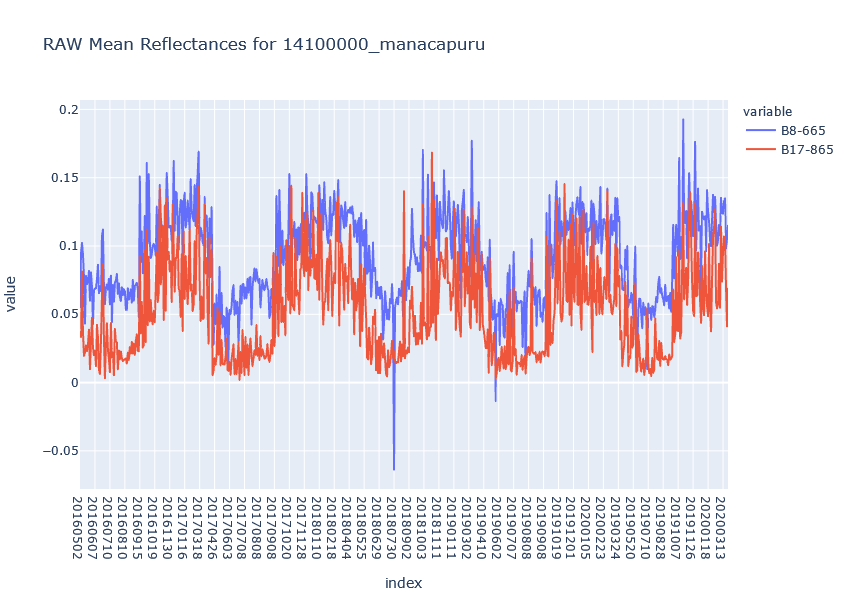

In [37]:
px.line(df_raw_mean, y=['B8-665','B17-865'], height=600, title="RAW Mean Reflectances for 14100000_manacapuru")

In [38]:
df_raw_norm_mean = pd.DataFrame()

for date, radiometry in raw_radiometries.items():
    radiometry = clean_radiometry(radiometry, min_threshold=-0.1, norm_band=1020) 
    df_raw_norm_mean = df_raw_norm_mean.append(radiometry.mean().rename(date))

df_raw_norm_mean['Date'] = [f'{i[:4]}-{i[4:6]}-{i[6:]}' for i, row in df_raw_norm_mean.iterrows()]

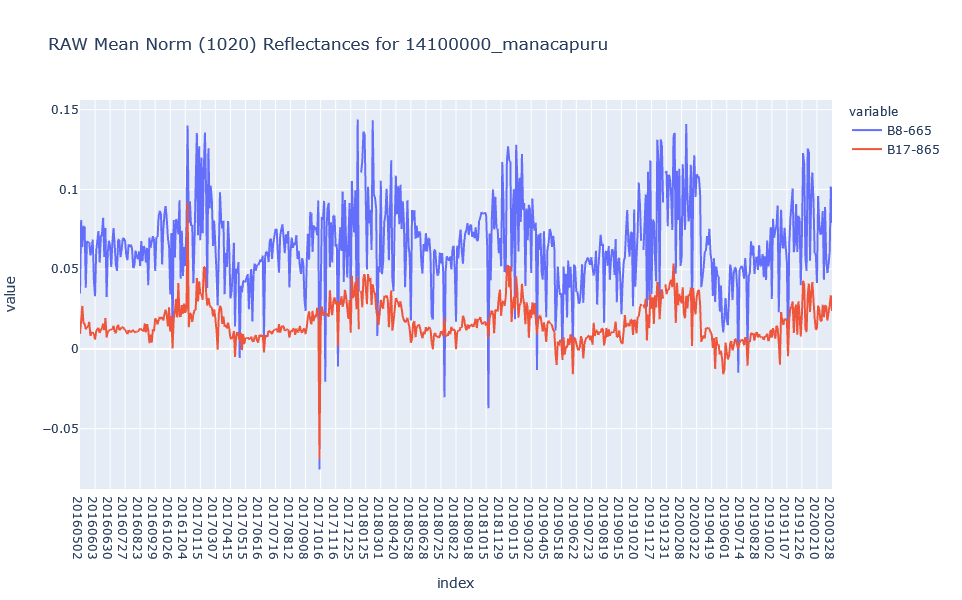

In [39]:
px.line(df_raw_norm_mean, y=['B8-665','B17-865'], height=600, title="RAW Mean Norm (1020) Reflectances for 14100000_manacapuru")

### L1 Sentine-3 Radiometries

In [40]:
base_path = v15_folders[3] # Manacapuru

In [41]:
# Get the complete list of raw.csv files inside the input folder.
csvs = datafolder_2_list(base_path)

In [42]:
# Create a empty dict to append the Pandas.DataFrame of each csv.
l1_radiometries = {}
min_pixels = 4 # Discard DFs with less than min_pixels

t1 = time.perf_counter()

for i, csv in enumerate(csvs):
    df = open_radiometry(csvs[i])
    if len(df) >= min_pixels:
        l1_radiometries[csv.stem[16:24]] = df

t2 = time.perf_counter()
outputstr = f'>>> Finished in {round(t2 - t1, 2)} second(s). <<<'
print(outputstr)

>>> Finished in 7.84 second(s). <<<


In [43]:
df_v15_mean = pd.DataFrame()

for date, radiometry in l1_radiometries.items():
    df_v15_mean = df_v15_mean.append(radiometry.mean().rename(date))

df_v15_mean['Date'] = [f'{i[:4]}-{i[4:6]}-{i[6:]}' for i, row in df_v15_mean.iterrows()]

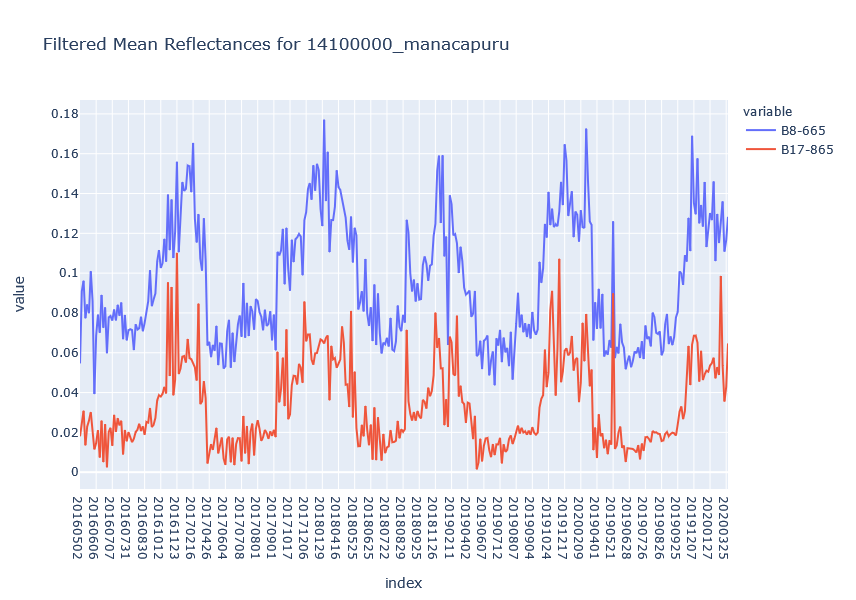

In [44]:
px.line(df_v15_mean, y=['B8-665','B17-865'], height=600, title="Filtered Mean Reflectances for 14100000_manacapuru")

In [45]:
df_v15_norm_mean = pd.DataFrame()

for date, radiometry in l1_radiometries.items():
    radiometry = clean_radiometry(radiometry, min_threshold=-0.1, norm_band=1020) 
    df_v15_norm_mean = df_v15_norm_mean.append(radiometry.mean().rename(date))

df_v15_norm_mean['Date'] = [f'{i[:4]}-{i[4:6]}-{i[6:]}' for i, row in df_v15_norm_mean.iterrows()]

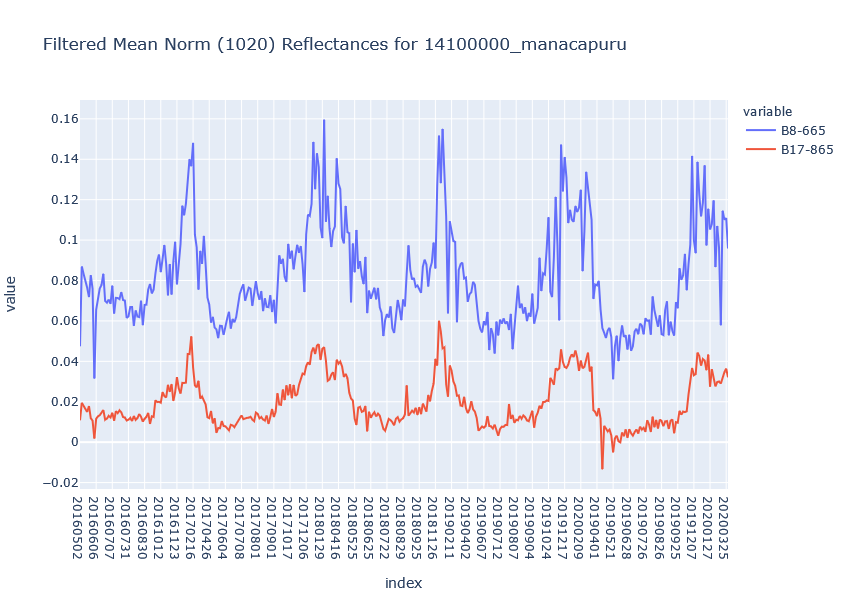

In [46]:
px.line(df_v15_norm_mean, y=['B8-665','B17-865'], height=600, title="Filtered Mean Norm (1020) Reflectances for 14100000_manacapuru")

## DBSCAN

In [4]:
radiometries = load_radiometries(Path(r'D:\processing\linux\14100000_manacapuru_v15'))

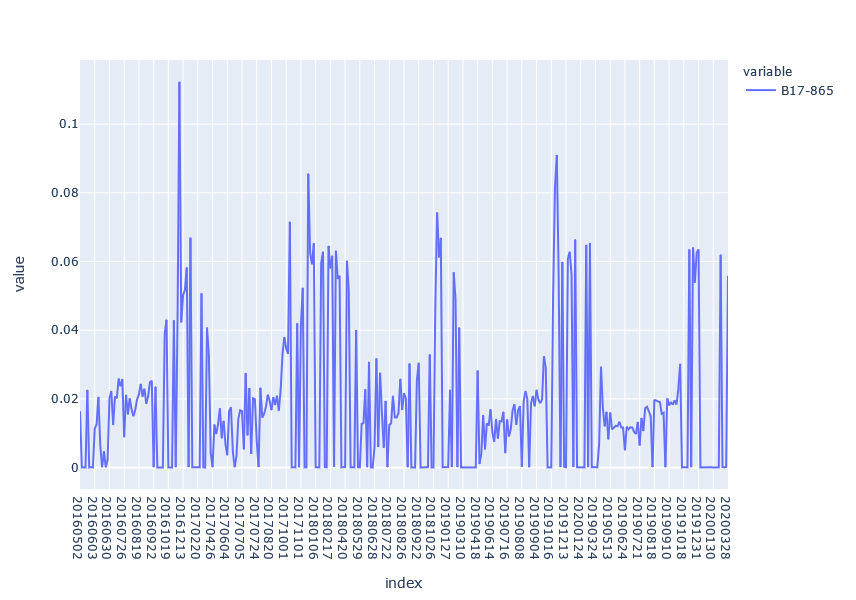

In [6]:
pd.options.mode.chained_assignment = None  # default='warn'

def create_time_series_cluster(radiometries, eps=0.01, min_samples=5):
    df = pd.DataFrame()

    for date, radiometry in radiometries.items():

        # clean some outliars  using the indices
        #calc_nd_index(radiometry, 'B6-560', 'B21-1020', column_name='mndwi')  # Green / SWIR
        #calc_nd_index(radiometry, 'B6-560', 'B17-865', column_name='ndwi')  # Green / IR

        #valid_mndwi = (radiometry['mndwi'] > -0.99) & (radiometry['mndwi'] < 0.99)
        #valid_ndwi = (radiometry['ndwi'] > -0.99) & (radiometry['ndwi'] < 0.99)

        #radiometry = radiometry[valid_mndwi & valid_ndwi]

        if len(radiometry) < min_samples:
            continue 
        
        db_scan(radiometry, ['B17-865', 'B21-1020'], eps=eps, min_samples=min_samples)
        clusters = radiometry.groupby(by='cluster').mean()

        # drop the noise
        clusters.drop(-1, inplace=True, errors='ignore')

        # if there is at least 1 valid cluster
        if len(clusters) > 0:
            df = df.append(clusters[clusters['B21-1020'] == clusters['B21-1020'].min()].iloc[0].rename(date))

    return df

df = create_time_series_cluster(radiometries)
px.line(df, y=['B17-865'], height=600,)

In [191]:
df['Date'] = [f'{i[:4]}-{i[4:6]}-{i[6:]}' for i, row in df.iterrows()]
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date',inplace=True)

## CAMS 2016:2020

In [175]:
camscsvfolder = Path('D:/A1_JM/artigo_SEN3R/2_mat_met/CAMS')

In [176]:
station2cams = [s for s in os.listdir(camscsvfolder) if s.endswith('.csv')]

In [177]:
cams_station_dict = {}
for s in station2cams:
    sname = s.split('.')[0]
    df = pd.read_csv(camscsvfolder/s)
    cams_station_dict[sname] = df

In [178]:
cams_station_dict['manacapuru']

,Datetime,AOD865
0,2016-01-01 06:00:00,0.447001
1,2016-01-01 12:00:00,0.485241
2,2016-01-01 18:00:00,0.290634
3,2016-01-02 06:00:00,0.259656
4,2016-01-02 12:00:00,0.203305
...,...,...
6937,2020-12-30 18:00:00,0.035058
6938,2020-12-31 00:00:00,0.049849
6939,2020-12-31 06:00:00,0.078216
6940,2020-12-31 12:00:00,0.099986


In [194]:
manacapuru_cams = cams_station_dict['manacapuru']
manacapuru_cams['pyate'] = pd.to_datetime(manacapuru_cams['Datetime'])

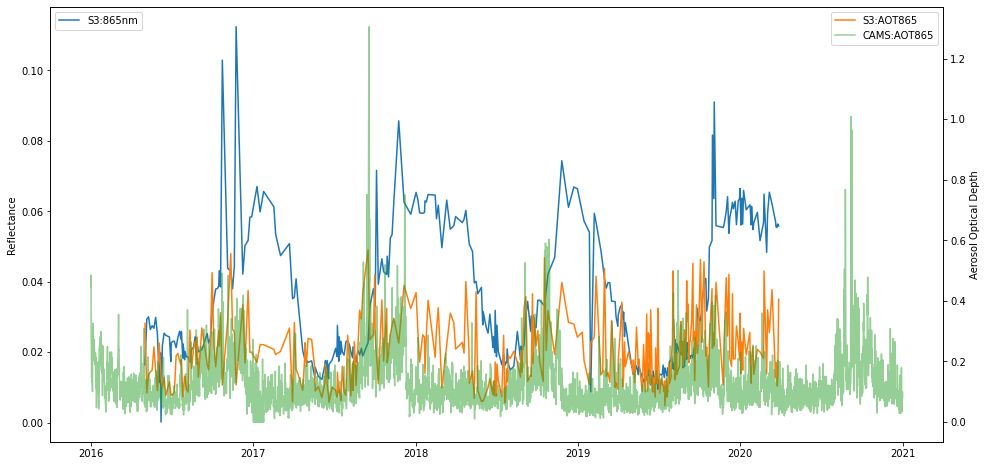

In [207]:
# create figure and axis objects with subplots()
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()

# make a plot
ax.plot(df['Date'], df['B17-865'], label='S3:865nm')
# ax.axis(ymin=0, ymax=0.2)

# set x-axis label
# ax.set_xlabel("year",fontsize=14)a

# set y-axis label
ax.set_ylabel("Reflectance")

ax.legend(loc=2)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(df['Date'], df['T865:float'], label='S3:AOT865', c='C1')
ax2.plot(manacapuru_cams['pyate'],manacapuru_cams['AOD865'], c='C2', alpha=0.5, label='CAMS:AOT865')

# ax2.plot(df_s3_srtd['Date'], df_s3_srtd['B17-865'], c='C1', label='Sentinel-3A')
ax2.set_ylabel("Aerosol Optical Depth")

ax2.legend(loc=9)

plt.legend()
plt.show()

## RAW vs v15 Match

In [86]:
dfr = df_raw_mean[['DateB17-865B8-665']].copy()
dfr['Date'] = pd.to_datetime(dfr['Date'])

In [87]:
df15n = df_v15_norm_mean[['Date','B8-665']].copy()
df15n['Date'] = pd.to_datetime(df15n['Date'])

In [88]:
dfr.sort_values(by='Date',inplace=True)
df15n.sort_values(by='Date',inplace=True)

In [89]:
dfr.reset_index(drop=True, inplace=True)
df15n.reset_index(drop=True, inplace=True)

In [95]:
# https://pandas.pydata.org/pandas-docs/version/0.25.0/reference/api/pandas.merge_asof.html
# https://stackoverflow.com/questions/49078479/merge-2-pandas-dataframes-by-dates-within-a-few-days-of-each-other
# '''
# Merge left and right DF, repeating the values from one-another when 
# '''
fusion = pd.merge_asof(dfr,df15n,on='Date',direction='nearest',suffixes=('_raw','_v15'))

In [96]:
fusion.index = fusion['Date']

In [97]:
fusion.iloc[0]

Date          2016-05-02 00:00:00
B8-665_raw              0.0551713
B8-665_v15              0.0474384
Name: 2016-05-02 00:00:00, dtype: object

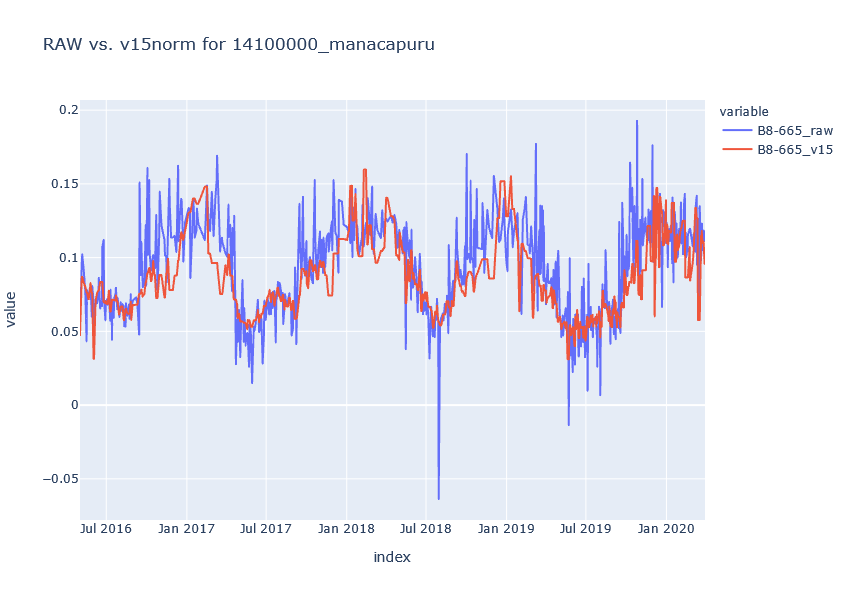

In [98]:
px.line(fusion, y=['B8-665_raw','B8-665_v15'], height=600, title="RAW vs. v15norm for 14100000_manacapuru")

## Match Sentinel-3 observations

In [103]:
mod_mats3 = terra[terra['Datetime'].isin(fusion['Date'])]
myd_mats3 = aqua[aqua['Datetime'].isin(fusion['Date'])]
vir_mats3 = viirs[viirs['Datetime'].isin(fusion['Date'])]

In [104]:
len(mod_mats3),len(myd_mats3),len(vir_mats3)

(629, 623, 632)

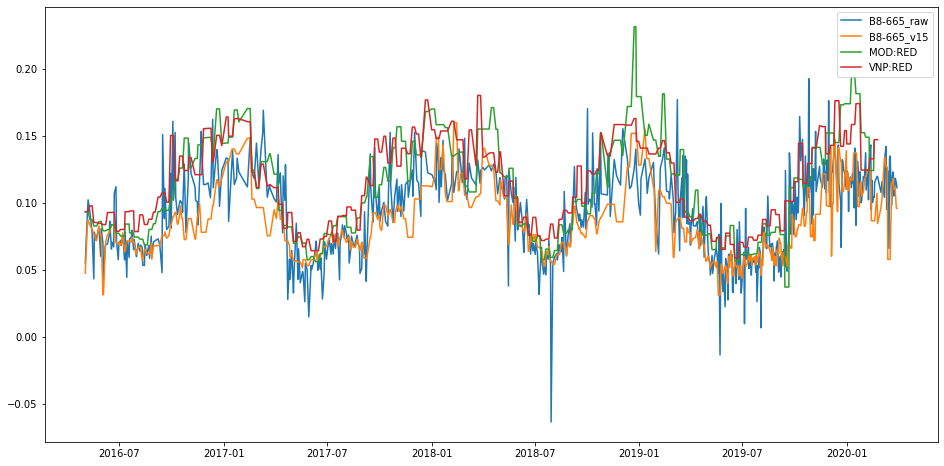

In [150]:
plt.figure(figsize=(16,8))

plt.plot(fusion['Date'],fusion['B8-665_raw'],label='B8-665_raw')
plt.plot(fusion['Date'],fusion['B8-665_v15'],label='B8-665_v15')
plt.plot(mod_mats3['Datetime'],mod_mats3['Bande rouge estimee']/10000,label='MOD:RED')
plt.plot(vir_mats3['Datetime'],vir_mats3['Bande rouge estimee']/10000,label='VNP:RED')

plt.legend()

## SPM

In [132]:
manacapuru_sed_xls = Path('D:/processing/linux/14100000_manacapuru_v15_sedimentos.xlsx')
# sed_xls = '/d_drive_data/processing/linux/14100000_manacapuru_v15.xlsx'

df_manacapuru_sed = pd.read_excel(manacapuru_sed_xls,sheet_name='sedimentos')

# Fix excel dates from ordinal (40603) to datetime.datetime(2011, 3, 1, 0, 0)
df_manacapuru_sed['pydate'] = [from_excel_ordinal(d) for d in df_manacapuru_sed['Data']]

# Reorder the DF by datetime 
df_manacapuru_sed.sort_values(by='py_date', inplace=True)

In [132]:
borba_sed_xls = Path('D:/processing/linux/15860000_borba_madeira_v15_sedimentos.xlsx')
# sed_xls = '/d_drive_data/processing/linux/14100000_manacapuru_v15.xlsx'

df_borba_sed = pd.read_excel(borba_sed_xls,sheet_name='sedimentos')

# Fix excel dates from ordinal (40603) to datetime.datetime(2011, 3, 1, 0, 0)
df_borba_sed['py_date'] = [from_excel_ordinal(d) for d in df_borba_sed['Data']]

# Reorder the DF by datetime 
df_borba_sed.sort_values(by='pydate', inplace=True)

In [132]:
obidos_sed_xls = Path('D:/processing/linux/17050001_obidos_v15b_sedimentos.xlsx')
# sed_xls = '/d_drive_data/processing/linux/14100000_manacapuru_v15.xlsx'

df_obidos_sed = pd.read_excel(obidos_sed_xls,sheet_name='sedimentos')

# Fix excel dates from ordinal (40603) to datetime.datetime(2011, 3, 1, 0, 0)
df_obidos_sed['py_date'] = [from_excel_ordinal(d) for d in df_obidos_sed['Data']]

# Reorder the DF by datetime 
df_obidos_sed.sort_values(by='pydate', inplace=True)

In [136]:
vir_mats3['SPM:GET:AMZ'] = SPM_GET_Amazon(b665=vir_mats3['Bande rouge estimee'], b865=vir_mats3['Bande IR estimee'])

In [137]:
df['SPM:GET:AMZ'] = SPM_GET_Amazon(b665=df['B8-665'], b865=df['B17-865'])

In [152]:
df_dbscan = df.copy()

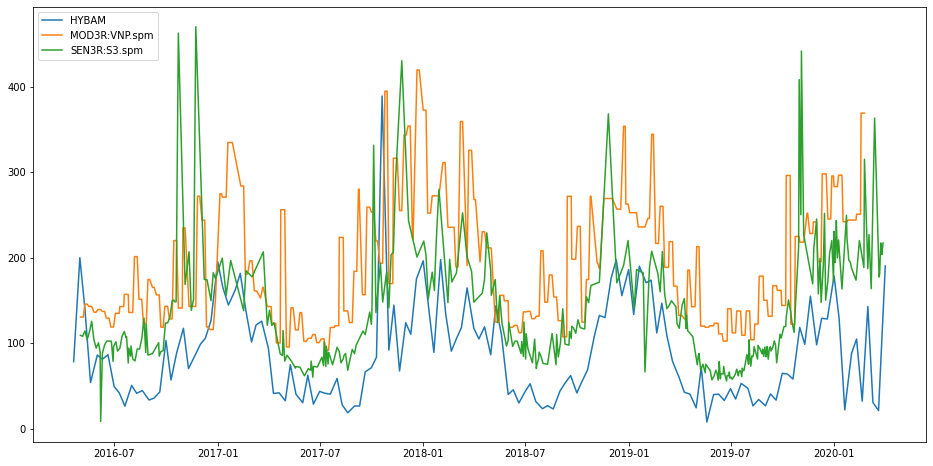

In [151]:
plt.figure(figsize=(16,8))

plt.plot(df_sed['py_date'],df_sed['Concentração (mg/L)'],label='HYBAM.spm')
plt.plot(vir_mats3['Datetime'],vir_mats3['SPM:GET:AMZ'],label='MOD3R:VNP.spm')
plt.plot(df['Date'],df['SPM:GET:AMZ'],label='SEN3R:S3.spm')

plt.legend()

In [153]:
df = radiometries['20161123']

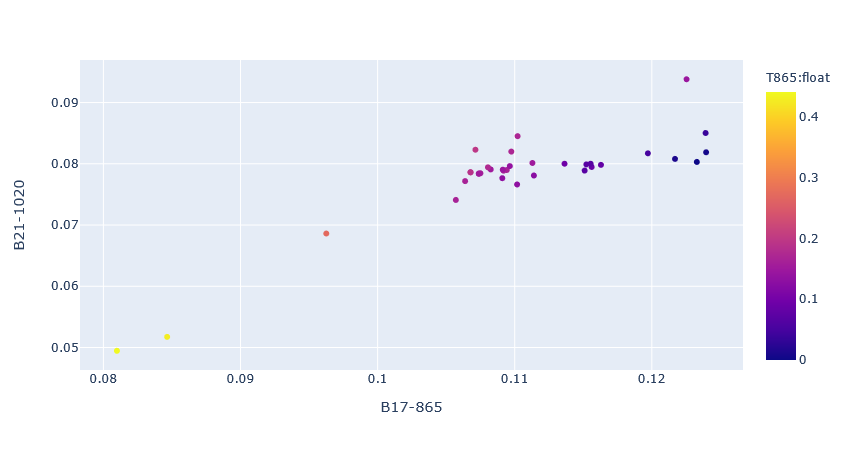

In [156]:
px.scatter(df, x=df['B17-865'], y=df['B21-1020'], color='T865:float')

In [158]:
db_scan(df, ['B17-865', 'B21-1020'], eps=0.01)

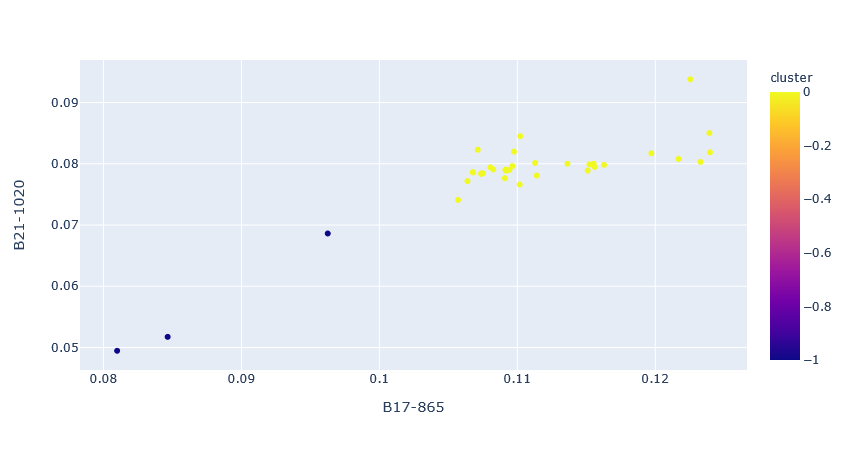

In [159]:
px.scatter(df, x=df['B17-865'], y=df['B21-1020'], color='cluster')

In [181]:
df = radiometries['20180729']

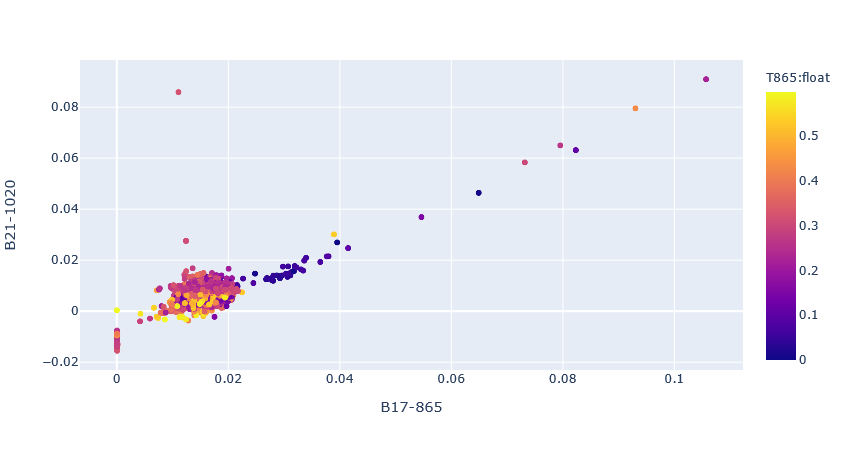

In [182]:
px.scatter(df, x=df['B17-865'], y=df['B21-1020'], color='T865:float')

In [183]:
db_scan(df, ['B17-865', 'B21-1020'], eps=0.01)

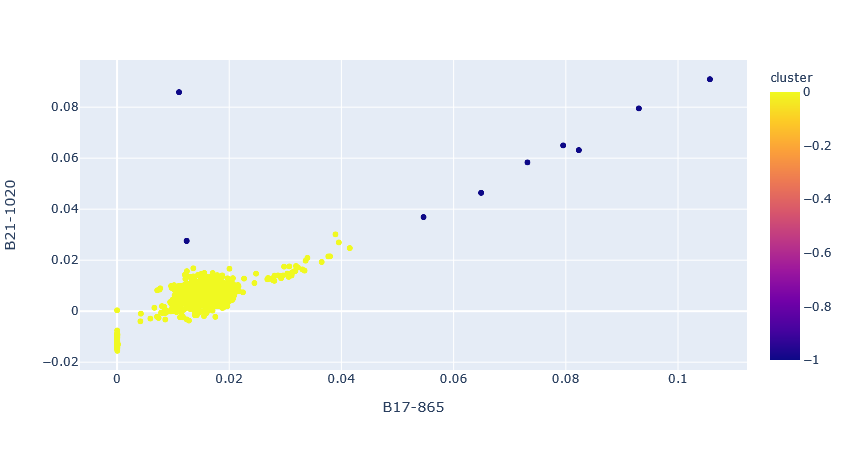

In [184]:
px.scatter(df, x=df['B17-865'], y=df['B21-1020'], color='cluster')